In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from virtual_rodent.environment import MAPPER
from virtual_rodent import VISION_DIM, PROPRI_DIM, ACTION_DIM
from virtual_rodent.network.vision_enc import ResNet18Enc
from virtual_rodent.network.propri_enc import MLPEnc
import virtual_rodent.network.Merel2019 as Merel2019
from virtual_rodent.utils import load_checkpoint

In [3]:
vision_enc = ResNet18Enc()
vision_emb_dim = vision_enc.get_emb_dim(VISION_DIM)

propri_emb_dim = 20 # propri_dim
propri_enc = MLPEnc(PROPRI_DIM[0], propri_emb_dim, hidden_dims=(50,))

critic_in_dim = vision_emb_dim + propri_emb_dim
critic = Merel2019.Critic(critic_in_dim)

actor_in_dim = critic_in_dim + PROPRI_DIM[0] + critic.hidden_dim
actor = Merel2019.Actor(actor_in_dim, ACTION_DIM, logit_scale=1)

model = Merel2019.MerelModel(vision_enc, propri_enc, VISION_DIM, PROPRI_DIM, 
                             actor, critic, ACTION_DIM) 

In [4]:
env_name = 'gaps'
env, propri_attr = MAPPER[env_name](physics_dt=0.001, ctrl_dt=0.02)

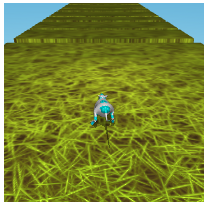

In [5]:
from virtual_rodent.visualization import video
from virtual_rodent.simulation import simulate
ext_cam = (0,)
save_dir = './'
ext_cam_size = (200, 200)
with torch.no_grad():
    ret = simulate(env, model, propri_attr, max_step=100, device=torch.device('cpu'), ext_cam=ext_cam)
for i in ext_cam:
    anim = video(ret['cam%d'%i])
    fname = 'demo_%s_cam%d.gif' % (env_name, i)
    anim.save(os.path.join(save_dir, fname), writer='pillow')

In [22]:
log_target = model(vision=torch.stack(ret['vision']).unsqueeze(1), 
                   propri=torch.stack(ret['propri']).unsqueeze(1),
                   actor_hc=model.actor.hc, critic_hc=model.critic.hc, 
                   action=torch.concat(ret['action']))[1][1]

In [23]:
torch.concat(ret['log_prob']).shape, log_target.shape

(torch.Size([5, 1, 38, 1]), torch.Size([5, 1, 38, 1]))

np.float64(0.3112296656009273)

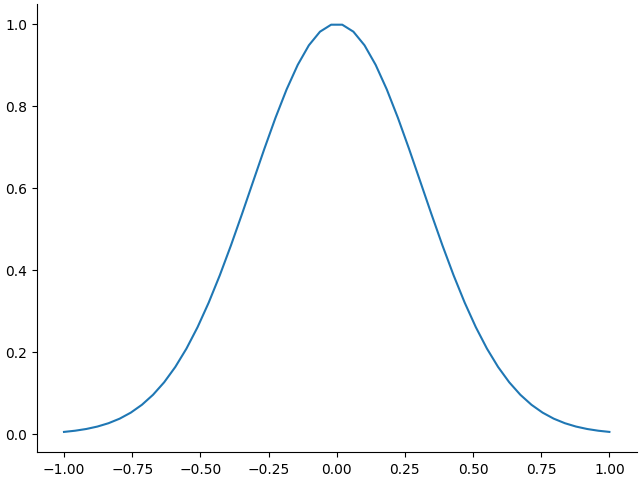

In [8]:
_ = np.linspace(-1, 1)
s = 0.5/(1+np.exp(-0.5))
plt.plot(_, np.exp(-_**2/2/s**2))
s

np.float64(4.93042110837996)

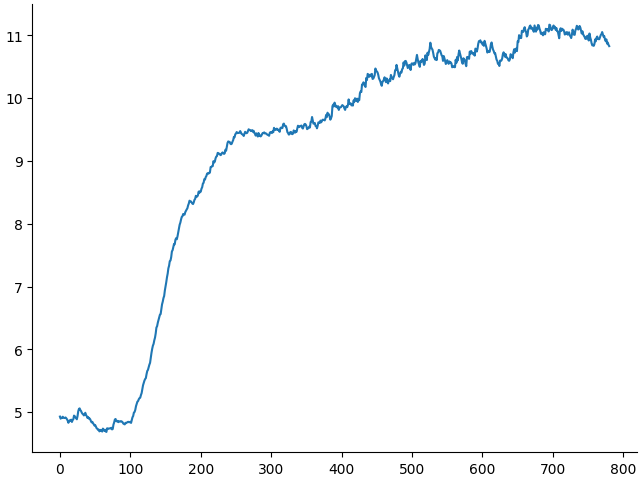

In [9]:
r = np.load('./results/reward.npy')
plt.plot(r)
r[0]

In [10]:
state_dicts = [torch.load(f'./results/weights{i}.pth', weights_only=True) 
               for i in range(500, 4001, 500)]